### To do


> Two datasets "MET-Meme & Memotion" (Multimodal image and text) offensive Meme detection 

> "Multiclass: Not offensive, slight offensive and very offensive" 

> Two Models Models are parallelly work: 
    on text (BERT and CNN) on images (RESNet-152, also comment ResNet-50) 
    Then Dense layer, fully concatenation layer and final multi classification (softmax). 
    Requirement is Dataset should be 7k or more also balance dataset. 
    Accuracy, recall, f1score, precision (validation and training loss graph), 
    (validation and training accuracy graph), (Confusion Matrix)

**Libraries**

In [1]:
rm -rf *pkl

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from PIL import Image
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import os

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision.models import resnet152
from transformers import BertModel, BertTokenizer

## EDA and Preprocessing

### *Dataset Path*

In [3]:
ROOT_PATH = "/kaggle/input/memotion-dataset-7k/memotion_dataset_7k"
ROOT_PATH2 = "/kaggle/input/met-meme"

In [4]:
data1 = pd.read_csv(f"{ROOT_PATH}/labels.csv")
# data.drop(columns= ["Unnamed: 0", "text_ocr", "humour", "sarcasm", "motivational", "overall_sentiment"],
#             inplace = True)
# data.columns = ["image_name", "text", "label"]


data1.drop(columns= ["Unnamed: 0","text_ocr", 'humour', 'sarcasm', 'motivational' , 'overall_sentiment'], inplace = True)
data1.columns = ["image_name", "text", "label"]

data1.head()

,image_name,text,label
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,not_offensive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_offensive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,not_offensive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_offensive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,very_offensive


In [5]:
labelDict = {'1(slightly)': 'slight', '0(non-offensive)':'not_offensive', '3(very)':'hateful_offensive', '2(moderately)':'very_offensive'}

In [6]:
data2 = pd.read_csv(f"{ROOT_PATH2}/E_text.csv", encoding = 'latin-1')
labelsDF = pd.read_csv(f"{ROOT_PATH2}/label_E.csv", encoding = 'latin-1')
labelsDF['offensiveness detection'] = labelsDF['offensiveness detection'].map(labelDict)
labelsDF.drop(columns=["sentiment category","sentiment degree", "intention detection", "metaphor occurrence", 
                       "metaphor category", "target domain", "source domain", "target modality", "source modality"], inplace=True)
labelsDF.columns = ['file_name', 'label']

data2.head()

,file_name,text
0,image_ (0).jpg,That moment after you throw up and your friend...
1,image_ (1).jpg,EVERYDAY IS CATURDAY IF you're a cat! I CATS
2,image_ (10).jpg,me\nfood at a potluck
3,image_ (100).jpg,My knowledge in love vs. My knowledge in theor...
4,image_ (101).jpg,My knowledge of Star \n Wars My knowledge of...


In [7]:
labelsDF.head()

,file_name,label
0,image_ (0).jpg,slight
1,image_ (1).jpg,not_offensive
2,image_ (10).jpg,not_offensive
3,image_ (100).jpg,slight
4,image_ (101).jpg,not_offensive


In [8]:
dataset2 = pd.merge(data2, labelsDF, on='file_name')
dataset2.columns = ['image_name', 'text', 'label']
dataset2

,image_name,text,label
0,image_ (0).jpg,That moment after you throw up and your friend...,slight
1,image_ (1).jpg,EVERYDAY IS CATURDAY IF you're a cat! I CATS,not_offensive
2,image_ (10).jpg,me\nfood at a potluck,not_offensive
3,image_ (100).jpg,My knowledge in love vs. My knowledge in theor...,slight
4,image_ (101).jpg,My knowledge of Star \n Wars My knowledge of...,not_offensive
...,...,...,...
3989,image_ (995).jpg,WHERE TO?\nDON'T YOU EVER DISINFECT THIS TAXI?,not_offensive
3990,image_ (996).jpg,you remember the first few weeks we were looki...,slight
3991,image_ (997).jpg,A neutron walks into a bar and asks how much f...,not_offensive
3992,image_ (998).jpg,WHAT IF THE BIG BANG WAS A RESET BUTTON FOR A ...,not_offensive


In [9]:
data = pd.concat([data1, dataset2])
data.head()

,image_name,text,label
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,not_offensive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_offensive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,not_offensive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_offensive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,very_offensive


In [10]:
import os
import shutil

NEW_ROOT_PATH = "/kaggle/working/data_images"

if os.path.exists(NEW_ROOT_PATH):
    # Use os.rmdir() to remove an empty directory
    shutil.rmtree(NEW_ROOT_PATH)
    print("Directory removed successfully.")

os.mkdir(NEW_ROOT_PATH)

source_folder1 = "/kaggle/input/memotion-dataset-7k/memotion_dataset_7k/images"
source_folder2 = "/kaggle/input/met-meme/Eimages/Eimages/Eimages"

def copy_images(source_folder, destination_folder):
    for filename in os.listdir(source_folder):
        shutil.copy(os.path.join(source_folder, filename), destination_folder)

# Copy images from source_folder1
copy_images(source_folder1, NEW_ROOT_PATH)

# Copy images from source_f`older2
copy_images(source_folder2, NEW_ROOT_PATH)



In [11]:
# os.listdir('/kaggle/working/data_images')

### Plot Distribution
> Plotting the distribution of Labels

In [12]:
def plot_distribution(df, column_name):
    
    Distribution = df[column_name].value_counts().to_dict()
    categories = list(Distribution.keys())
    values = list(Distribution.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=categories, y=values, palette='Set2')
    for i, v in enumerate(values):
        plt.text(i, v + 50, str(v), ha='center', va='bottom')
    plt.xlabel('Offensiveness Categories')
    plt.ylabel('Frequency')
    plt.title('Frequency of Offensiveness Categories')
    plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()



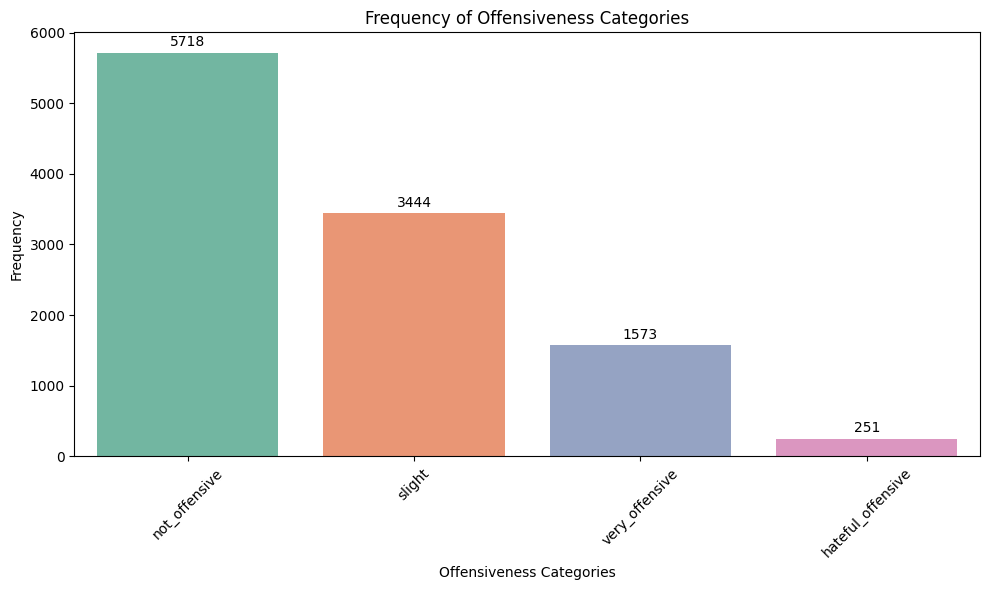

In [13]:
plot_distribution(data, "label")

### Balancing the Dataset

> merged "very_offensive" & "hateful_offensive" as 'very_offensive'

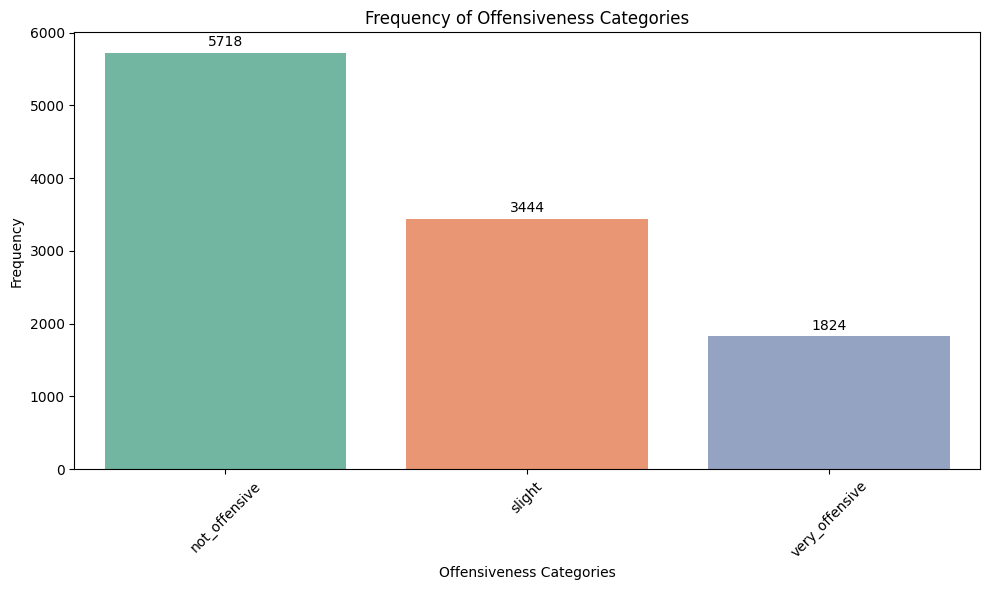

In [14]:
import pandas as pd

# Merge 'very_offensive' and 'hateful_offensive' into one category
data['label'] = data['label'].replace({ 'hateful_offensive': 'very_offensive'})
plot_distribution(data, "label")


In [15]:
import json
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW, SGD
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
import pandas as pd

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
device

device(type='cuda')

In [17]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=ae181b8bc9c1d5158aa50cf7ed06c97c4740c9d8579fd3dd21413859216b90fd
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [18]:
import os
ALBEF_FOLDER = 'ALBEF/'
os.makedirs(ALBEF_FOLDER, exist_ok=True)

In [19]:
# download pre-trained ALBEF model and required ALBEF files from ALBEF's official repo (only need to do this once to save it in your gdrive)
!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/vit.py -O $ALBEF_FOLDER/vit.py
!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/tokenization_bert.py -O $ALBEF_FOLDER/tokenization_bert.py
!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/xbert.py -O $ALBEF_FOLDER/xbert.py


--2024-05-15 05:13:49--  https://raw.githubusercontent.com/salesforce/ALBEF/main/models/vit.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8558 (8.4K) [text/plain]
Saving to: 'ALBEF//vit.py'

ALBEF//vit.py       100%[===================>]   8.36K  --.-KB/s    in 0s      

2024-05-15 05:13:49 (38.7 MB/s) - 'ALBEF//vit.py' saved [8558/8558]

--2024-05-15 05:13:50--  https://raw.githubusercontent.com/salesforce/ALBEF/main/models/tokenization_bert.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24750 (24K) [text/plain]
Saving t

In [20]:
# replace all occurrences of tokenizer_class with processor_class in xbert.py to make it compatible with newer transformers version
# if you don't do this step, you will need to install transformers==4.8.1 as specified by the requirements in the ALBEF repo

!sed -i 's/tokenizer_class/processor_class/g' $ALBEF_FOLDER/xbert.py

In [21]:
# add path to downloaded ALBEF files
import sys
sys.path.append(ALBEF_FOLDER)

#import libraries required for ALBEF
from vit import VisionTransformer
from xbert import BertConfig as AlbefBertConfig, BertModel as AlbefBertModel
from functools import partial
import numpy as np

In [22]:
data = data.dropna(axis=0)

In [23]:
# Perform one-hot encoding
data = pd.get_dummies(data, columns=['label'], prefix = "", 
                            prefix_sep = "",dtype = "float32")
data

,image_name,text,not_offensive,slight,very_offensive
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,1.0,0.0,0.0
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,1.0,0.0,0.0
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,1.0,0.0,0.0
3,image_4.png,10 Year Challenge - Sweet Dee Edition,0.0,0.0,1.0
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,0.0,0.0,1.0
...,...,...,...,...,...
3989,image_ (995).jpg,WHERE TO?\nDON'T YOU EVER DISINFECT THIS TAXI?,1.0,0.0,0.0
3990,image_ (996).jpg,you remember the first few weeks we were looki...,0.0,1.0,0.0
3991,image_ (997).jpg,A neutron walks into a bar and asks how much f...,1.0,0.0,0.0
3992,image_ (998).jpg,WHAT IF THE BIG BANG WAS A RESET BUTTON FOR A ...,1.0,0.0,0.0


In [29]:
import pickle
def load_all_images_and_text(df, path):
    images_paths = df['image_name'].to_list()
    text = df['text'].to_list()
    notOff = data['not_offensive'].to_list()
    slightOff = data['slight'].to_list()
    veryOff = data['very_offensive'].to_list()
    texts = []
#     label = df['label'].to_list()
    labels = []
    images = []
    for ind, filename in enumerate(images_paths):
        try:
            img = Image.open(os.path.join(path,filename)).convert('RGB')
        except:
            continue
        images.append(img)
        texts.append(text[ind])
        labels.append([notOff[ind], slightOff[ind], veryOff[ind]])

    return texts, images, labels

text, images, labels = load_all_images_and_text(data, path = NEW_ROOT_PATH)

with open("text", "wb") as fp:
    pickle.dump(text, fp)

with open("images", "wb") as fp:
    pickle.dump(images, fp)

with open("labels", "wb") as fp:
    pickle.dump(labels, fp)

In [30]:
len(images)

10922

In [31]:
len(text)

10922

In [32]:
len(labels)

10922

In [43]:
class AlbefDataset(Dataset):
    def __init__(self, text, images, label):
        self.text = text
        self.images = images
        self.label = label

        # ALBEF settings
        self.img_size = 256
        self.mean, self.std = (
            0.40821073), (0.26862954)


        self.train_transform_func = transforms.Compose(
                [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])

                    
    def __getitem__(self, idx):
        text = self.text[idx]
        label = self.label[idx]
        image = self.images[idx]
        
        
        img = self.train_transform_func(image)

        return text, img, torch.tensor(label)

    def __len__(self):
        return len(self.text)

dataset = AlbefDataset(text, images, labels)
dataset[2]

("Sam Thorne @Strippin ( Follow Follow Saw everyone posting these 2009 vs 2019 pics so here's mine 6:23 PM - 12 Jan 2019 O 636 Retweets 3 224 LIKES 65 636 3.2K",
 tensor([[[ 2.2030,  2.2030,  2.2030,  ..., -1.1108, -1.1108, -1.1254],
          [ 2.2030,  2.2030,  2.2030,  ..., -1.1108, -1.1108, -1.1254],
          [ 2.2030,  2.2030,  2.2030,  ..., -1.1108, -1.1108, -1.1108],
          ...,
          [ 2.1738,  2.1738,  2.1738,  ...,  0.3344,  0.3344,  0.3344],
          [ 2.2030,  2.2030,  2.2030,  ...,  0.3344,  0.3344,  0.3344],
          [ 2.2030,  2.2030,  2.2030,  ...,  0.3344,  0.3344,  0.3344]],
 
         [[ 2.2030,  2.2030,  2.2030,  ..., -0.9211, -0.9211, -0.9357],
          [ 2.2030,  2.2030,  2.2030,  ..., -0.9211, -0.9211, -0.9357],
          [ 2.1884,  2.1884,  2.1884,  ..., -0.9211, -0.9211, -0.9357],
          ...,
          [ 2.1738,  2.1738,  2.1738,  ...,  0.3344,  0.3344,  0.3344],
          [ 2.2030,  2.2030,  2.2030,  ...,  0.3344,  0.3344,  0.3344],
          [ 2

In [44]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [45]:
class AlbefModel(nn.Module):

    def __init__(self, bert_config, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()

        self.num_labels = num_labels
        self.text_encoder = AlbefBertModel.from_pretrained(
            text_pretrained, config=bert_config, add_pooling_layer=False)

        self.visual_encoder = VisionTransformer(
            img_size=256, patch_size=16, embed_dim=768, depth=12, num_heads=12,
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

        self.classifier = nn.Linear(
            self.text_encoder.config.hidden_size, num_labels)
        
    
    def forward(self, text, image):
        image_embeds = self.visual_encoder(image)
        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(image_embeds.device)
        output = self.text_encoder(text.input_ids, attention_mask=text.attention_mask,
                                   encoder_hidden_states=image_embeds, encoder_attention_mask=image_atts, return_dict=True
                                   )
        logits = self.classifier(output.last_hidden_state[:, 0, :])
        return logits

In [46]:
from urllib.request import urlretrieve

def load_albef_pretrained(num_out_labels):
    tmp_directory = './tmp/albef'
    os.makedirs(tmp_directory, exist_ok=True)

    albef_bert_config_fp = os.path.join(tmp_directory, 'config_bert.json')
    albef_model_fp = os.path.join(tmp_directory, 'ALBEF.pth')

    if not os.path.exists(albef_bert_config_fp):
        urlretrieve("https://raw.githubusercontent.com/salesforce/ALBEF/main/configs/config_bert.json", albef_bert_config_fp)

    if not os.path.exists(albef_model_fp):
        urlretrieve("https://storage.googleapis.com/sfr-pcl-data-research/ALBEF/ALBEF_4M.pth", albef_model_fp)

    albef_bert_config = AlbefBertConfig.from_json_file(albef_bert_config_fp)
    albef_model = AlbefModel(bert_config=albef_bert_config, num_labels=num_out_labels)

    print(albef_model_fp)
    albef_checkpoint = torch.load(albef_model_fp, map_location='cpu')
    albef_state_dict = albef_checkpoint['model']

    for key in list(albef_state_dict.keys()):
        if 'bert' in key:
            encoder_key = key.replace('bert.', '')
            albef_state_dict[encoder_key] = albef_state_dict[key]
            del albef_state_dict[key]

    msg = albef_model.load_state_dict(albef_state_dict, strict=False)
    print("ALBEF checkpoint loaded from ", albef_model_fp)
    # print(msg)
    return albef_model

In [47]:
albef_model = load_albef_pretrained(num_out_labels=3)

./tmp/albef/ALBEF.pth
ALBEF checkpoint loaded from  ./tmp/albef/ALBEF.pth


In [48]:
albef_model.parameters()

<generator object Module.parameters at 0x7ef543b36180>

In [49]:
from transformers import AutoImageProcessor
import numpy as np

# b_inputs = bert_tokenizer(
#             "not hello", truncation=True, max_length=512,
#             return_tensors="pt", padding='max_length'
#         ).to(device)

# # b_inputs = b_inputs.to(device)
# b_imgs = Image.open(NEW_ROOT_PATH + "/image_445.jpg")
# b_imgs = b_imgs.resize((256,256))
# b_imgs = torch.Tensor(np.array(b_imgs)).unsqueeze(0).permute(0, 3, 1, 2).to(device)
# b_inputs, b_imgs.shape
# b_imgs = b_imgs.to(device)

In [52]:
train_data_loader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)
train_data_loader

In [53]:
from torchvision.ops import sigmoid_focal_loss
num_train_epochs = 5
learning_rate = 0.0005
t_total = len(train_data_loader) * num_train_epochs


optimizer = SGD(albef_model.parameters(), lr=learning_rate)
# scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=0, num_training_steps=t_total)

criterion = sigmoid_focal_loss

In [ ]:
torch.cuda.empty_cache()
albef_model = albef_model.to(device)
albef_model.train()

for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0
    correct = 0
    total = 0

    for step, batch in tqdm(enumerate(train_data_loader), total=len(train_data_loader), desc='Batch'):        
        b_text, b_imgs, b_labels, = batch  
        # print(b_text, b_imgs, b_labels)
        # break
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=128,
            return_tensors="pt", padding='max_length'
        )
        
        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        albef_model.zero_grad()        
        b_logits = albef_model(text=b_inputs, image=b_imgs).squeeze(1)
        
        loss = criterion(b_logits.to(torch.float32), b_labels.to(torch.float32), reduction = 'mean')

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        # scheduler.step()
        
        _, predicted = torch.max(b_logits, 1)
        total += b_labels.size(0)
        correct += (predicted == torch.argmax(b_labels, 1)).sum().item()
        
    avg_loss = epoch_total_loss/len(train_data_loader)

    print('epoch =', epoch_num)
    print("Accuracy:", correct/total)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/683 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 15.76297711301595
    avg_epoch_loss = 0.023079029448046778
    learning rate = 0.0005


Batch:   0%|          | 0/683 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 3.1123137273825705
    avg_epoch_loss = 0.004556828297778288
    learning rate = 0.0005


Batch:   0%|          | 0/683 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 1.6859588886145502
    avg_epoch_loss = 0.002468461037503002
    learning rate = 0.0005


Batch:   0%|          | 0/683 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 1.1459681848064065
    avg_epoch_loss = 0.0016778450729229963
    learning rate = 0.0005


Batch:   0%|          | 0/683 [00:00<?, ?it/s]